# Segmentacja nczyń krwionośnych dna oka z wykorzystaniem U net
## Autorzy:
- Jędrzej Warczyński 148234

## Wykorzytyswane biblioteki

In [136]:
import numpy as np
from matplotlib import pyplot as plt

from tabulate import tabulate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


from tqdm import tqdm
import cv2
import os

import tensorflow as tf

In [137]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Zdefinowanie ścieżki do zdjęć
źródło danych:
https://www5.cs.fau.de/research/data/fundus-images/

In [138]:
DATA_FOLDER = "drive/MyDrive/data"
IMAGES_FOLDER = os.path.join(DATA_FOLDER, "images")
MANUAL_FOLDER = os.path.join(DATA_FOLDER, "manual")
FOV_MASK_FOLDER = os.path.join(DATA_FOLDER, "mask")

MODEL_FOLDER = "drive/MyDrive"

In [140]:
filenames = os.listdir(IMAGES_FOLDER)
filenames.sort()
IMAGES_NUM = len(filenames)
IMAGES_NUM

45

In [141]:
TRAIN_IMAGES_NUM = 40

In [142]:
img_path = os.path.join(IMAGES_FOLDER, filenames[0])
filenames[0]
img_path
img = cv2.imread(img_path) 
img.shape

(2336, 3504, 3)

## Zdefinowanie zbioru treningowego z pierwszych 40 z 45 zdjęć

In [143]:
X_train = np.zeros((TRAIN_IMAGES_NUM, *img.shape), dtype=np.uint8)
X_train.shape

(40, 2336, 3504, 3)

## Pobranie maski espereckiej dla zbioru treningowego

In [144]:
Y_train = np.zeros((TRAIN_IMAGES_NUM, *img.shape[:2], 1), dtype=bool)
Y_train.shape

(40, 2336, 3504, 1)

## Przygotowanie zbioru treningowego
konwersja zdjęć do tablicy numpy o wymaganym wymiarze

In [145]:
for i, filename in tqdm(enumerate(filenames[:TRAIN_IMAGES_NUM]), total=TRAIN_IMAGES_NUM):
  img_path = os.path.join(IMAGES_FOLDER, filename)
  manual_path = os.path.join(MANUAL_FOLDER, filename.split('.')[0] + '.tif')

  X_train[i] = cv2.imread(img_path) 

  mask = np.zeros((*img.shape[:2], 1))
  manual = cv2.imread(manual_path, cv2.IMREAD_GRAYSCALE)
  manual_extended = np.expand_dims(manual, -1)
  mask = np.maximum(mask, manual_extended)
  Y_train[i] = mask

100%|██████████| 40/40 [00:10<00:00,  3.74it/s]


In [148]:
X_train.shape

(40, 2336, 3504, 3)

In [149]:
Y_train.shape

(40, 2336, 3504, 1)

## Zdefinowanie modelu sieci U-net z wykorzytsaniem biblioteki keras

In [150]:
inputs = tf.keras.layers.Input((img.shape))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 2336, 3504,  0           []                               
                                 3)]                                                              
                                                                                                  
 lambda_2 (Lambda)              (None, 2336, 3504,   0           ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 2336, 3504,   448         ['lambda_2[0][0]']               
                                16)                                                         

In [152]:
model_path = os.path.join(MODEL_FOLDER, "U_net_model_vessels")

### Wczesne zatrzymywanie w celu zapobiegania przeuczeniu oraz zapisywanie modelu dla przy poprawie wyniku

In [153]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(model_path, verbose=1, save_best_only=True)
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
        checkpointer]

## Trenowanie modelu

In [56]:
results = model.fit(X_train, Y_train, validation_split=0.2, batch_size=1, epochs=25, callbacks=callbacks, verbose=2)

Epoch 1/25

Epoch 1: val_loss improved from inf to 0.27876, saving model to drive/MyDrive/U_net_model_vessels


32/32 - 59s - loss: 0.3505 - accuracy: 0.9116 - val_loss: 0.2788 - val_accuracy: 0.9189 - 59s/epoch - 2s/step
Epoch 2/25

Epoch 2: val_loss improved from 0.27876 to 0.25499, saving model to drive/MyDrive/U_net_model_vessels


32/32 - 53s - loss: 0.2553 - accuracy: 0.9236 - val_loss: 0.2550 - val_accuracy: 0.9189 - 53s/epoch - 2s/step
Epoch 3/25

Epoch 3: val_loss improved from 0.25499 to 0.24359, saving model to drive/MyDrive/U_net_model_vessels


32/32 - 53s - loss: 0.2395 - accuracy: 0.9236 - val_loss: 0.2436 - val_accuracy: 0.9189 - 53s/epoch - 2s/step
Epoch 4/25

Epoch 4: val_loss improved from 0.24359 to 0.24230, saving model to drive/MyDrive/U_net_model_vessels


32/32 - 53s - loss: 0.2388 - accuracy: 0.9236 - val_loss: 0.2423 - val_accuracy: 0.9189 - 53s/epoch - 2s/step
Epoch 5/25

Epoch 5: val_loss improved from 0.24230 to 0.23262, saving model to drive/MyDrive/U_net_model_vessels


32/32 - 54s - loss: 0.2317 - accuracy: 0.9236 - val_loss: 0.2326 - val_accuracy: 0.9204 - 54s/epoch - 2s/step
Epoch 6/25

Epoch 6: val_loss did not improve from 0.23262
32/32 - 47s - loss: 0.2244 - accuracy: 0.9151 - val_loss: 0.2412 - val_accuracy: 0.9211 - 47s/epoch - 1s/step
Epoch 7/25

Epoch 7: val_loss improved from 0.23262 to 0.22941, saving model to drive/MyDrive/U_net_model_vessels


32/32 - 52s - loss: 0.2253 - accuracy: 0.9241 - val_loss: 0.2294 - val_accuracy: 0.9189 - 52s/epoch - 2s/step
Epoch 8/25

Epoch 8: val_loss improved from 0.22941 to 0.18721, saving model to drive/MyDrive/U_net_model_vessels


32/32 - 52s - loss: 0.1820 - accuracy: 0.9348 - val_loss: 0.1872 - val_accuracy: 0.9341 - 52s/epoch - 2s/step
Epoch 9/25

Epoch 9: val_loss did not improve from 0.18721
32/32 - 47s - loss: 0.1504 - accuracy: 0.9496 - val_loss: 0.1904 - val_accuracy: 0.9391 - 47s/epoch - 1s/step
Epoch 10/25

Epoch 10: val_loss improved from 0.18721 to 0.13426, saving model to drive/MyDrive/U_net_model_vessels


32/32 - 52s - loss: 0.1323 - accuracy: 0.9550 - val_loss: 0.1343 - val_accuracy: 0.9539 - 52s/epoch - 2s/step
Epoch 11/25

Epoch 11: val_loss did not improve from 0.13426
32/32 - 48s - loss: 0.1242 - accuracy: 0.9577 - val_loss: 0.1775 - val_accuracy: 0.9473 - 48s/epoch - 1s/step
Epoch 12/25

Epoch 12: val_loss did not improve from 0.13426
32/32 - 47s - loss: 0.1320 - accuracy: 0.9553 - val_loss: 0.1380 - val_accuracy: 0.9499 - 47s/epoch - 1s/step
Epoch 13/25

Epoch 13: val_loss improved from 0.13426 to 0.13171, saving model to drive/MyDrive/U_net_model_vessels


32/32 - 53s - loss: 0.1190 - accuracy: 0.9596 - val_loss: 0.1317 - val_accuracy: 0.9539 - 53s/epoch - 2s/step
Epoch 14/25

Epoch 14: val_loss improved from 0.13171 to 0.11624, saving model to drive/MyDrive/U_net_model_vessels


32/32 - 52s - loss: 0.1110 - accuracy: 0.9616 - val_loss: 0.1162 - val_accuracy: 0.9560 - 52s/epoch - 2s/step
Epoch 15/25

Epoch 15: val_loss improved from 0.11624 to 0.11538, saving model to drive/MyDrive/U_net_model_vessels


32/32 - 54s - loss: 0.1070 - accuracy: 0.9624 - val_loss: 0.1154 - val_accuracy: 0.9560 - 54s/epoch - 2s/step
Epoch 16/25

Epoch 16: val_loss did not improve from 0.11538
32/32 - 47s - loss: 0.1075 - accuracy: 0.9626 - val_loss: 0.1178 - val_accuracy: 0.9557 - 47s/epoch - 1s/step
Epoch 17/25

Epoch 17: val_loss did not improve from 0.11538
32/32 - 47s - loss: 0.1038 - accuracy: 0.9634 - val_loss: 0.1309 - val_accuracy: 0.9538 - 47s/epoch - 1s/step
Epoch 18/25

Epoch 18: val_loss improved from 0.11538 to 0.10544, saving model to drive/MyDrive/U_net_model_vessels


32/32 - 55s - loss: 0.1041 - accuracy: 0.9633 - val_loss: 0.1054 - val_accuracy: 0.9628 - 55s/epoch - 2s/step
Epoch 19/25

Epoch 19: val_loss did not improve from 0.10544
32/32 - 48s - loss: 0.0962 - accuracy: 0.9653 - val_loss: 0.1073 - val_accuracy: 0.9613 - 48s/epoch - 1s/step
Epoch 20/25

Epoch 20: val_loss improved from 0.10544 to 0.10394, saving model to drive/MyDrive/U_net_model_vessels


32/32 - 52s - loss: 0.1048 - accuracy: 0.9624 - val_loss: 0.1039 - val_accuracy: 0.9644 - 52s/epoch - 2s/step
Epoch 21/25

Epoch 21: val_loss improved from 0.10394 to 0.10242, saving model to drive/MyDrive/U_net_model_vessels


32/32 - 53s - loss: 0.0970 - accuracy: 0.9655 - val_loss: 0.1024 - val_accuracy: 0.9617 - 53s/epoch - 2s/step
Epoch 22/25

Epoch 22: val_loss did not improve from 0.10242
32/32 - 47s - loss: 0.0931 - accuracy: 0.9660 - val_loss: 0.1030 - val_accuracy: 0.9643 - 47s/epoch - 1s/step
Epoch 23/25

Epoch 23: val_loss improved from 0.10242 to 0.09284, saving model to drive/MyDrive/U_net_model_vessels


32/32 - 52s - loss: 0.0964 - accuracy: 0.9650 - val_loss: 0.0928 - val_accuracy: 0.9659 - 52s/epoch - 2s/step
Epoch 24/25

Epoch 24: val_loss improved from 0.09284 to 0.09111, saving model to drive/MyDrive/U_net_model_vessels


32/32 - 52s - loss: 0.0940 - accuracy: 0.9660 - val_loss: 0.0911 - val_accuracy: 0.9667 - 52s/epoch - 2s/step
Epoch 25/25

Epoch 25: val_loss did not improve from 0.09111
32/32 - 47s - loss: 0.0903 - accuracy: 0.9669 - val_loss: 0.0960 - val_accuracy: 0.9632 - 47s/epoch - 1s/step


In [169]:
TEST_SIZE = len(filenames) - TRAIN_IMAGES_NUM
TEST_SIZE

5

In [154]:
X_test = np.zeros((TEST_SIZE, *img.shape), dtype=np.uint8)
X_test.shape

(5, 2336, 3504, 3)

In [155]:
Y_test = np.zeros((TEST_SIZE, *img.shape[:2], 1), dtype=np.uint8)
Y_test.shape

(5, 2336, 3504, 1)

## Przygotowanie danych testowych

In [156]:
for i, filename in tqdm(enumerate(filenames[TRAIN_IMAGES_NUM:]), total=TEST_SIZE):
  img_path = os.path.join(IMAGES_FOLDER, filename)
  manual_path = os.path.join(MANUAL_FOLDER, filename.split('.')[0] + '.tif')

  X_test[i] = cv2.imread(img_path) 
  Y_test[i] = np.expand_dims(cv2.imread(manual_path, cv2.IMREAD_GRAYSCALE),-1)

100%|██████████| 5/5 [00:00<00:00,  6.32it/s]


## Wyznaczenie predykcji

In [62]:
predictions = model.predict(X_test, batch_size=1)
predictions.shape

5/5 [==============================] - 1s 263ms/step


(5, 2336, 3504, 1)

## Wyzanczenie dokładnośći predykcji na zbiorze testowym

In [65]:
_, accuracy = model.evaluate(X_test, Y_test, batch_size=1)
accuracy

5/5 [==============================] - 2s 268ms/step - loss: -3.6019 - accuracy: 0.9201


0.9201115369796753

## Pobranie wytrenowanego modelu z pliku po wcześniejszym zapisaniu

In [158]:
loaded_model = tf.keras.models.load_model(model_path)
_, loaded_accuracy = loaded_model.evaluate(X_test, Y_test, batch_size=1)
loaded_accuracy

5/5 [==============================] - 2s 242ms/step - loss: -23.1765 - accuracy: 0.9155


0.915465772151947

## Wizualizacja przykładowej maski wygenrowanej przez model

(-0.5, 3503.5, 2335.5, -0.5)

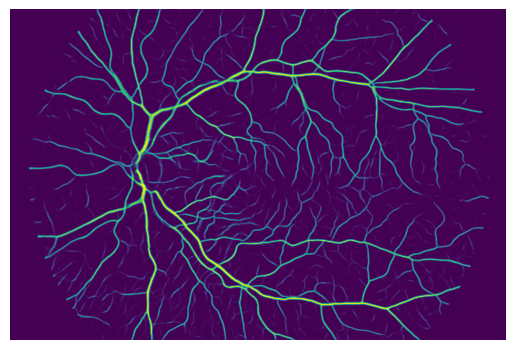

In [159]:
plt.imshow(predictions[0])
plt.axis("off")

## Klasa do wyzanaczania i wizualizacji metryk

In [160]:
class MetricsVisualizer:
    def __init__(self, ground_truth, predicted):
        self.ground_truth = ground_truth
        self.predicted = predicted

        self.TP = None
        self.TN = None
        self.FP = None
        self.FN = None

        self.accuracy = None
        self.sensitivity = None
        self.specificity = None

    def calculate_metrics(self):
        self.TP = np.sum(np.logical_and(self.ground_truth == 255, self.predicted == 255))
        self.TN = np.sum(np.logical_and(self.ground_truth == 0, self.predicted == 0))
        self.FP = np.sum(np.logical_and(self.ground_truth == 0, self.predicted == 255))
        self.FN = np.sum(np.logical_and(self.ground_truth == 255, self.predicted == 0))

        self.accuracy = (self.TP + self.TN) / (self.TP + self.TN + self.FP + self.FN)
        self.sensitivity = self.TP / (self.TP + self.FN)
        self.specificity = self.TN / (self.TN + self.FP)

    def visualize_metrics(self):
        self.tabulate_metrics()
        self.show_expert_predicted_and_misclassified()
        self.show_confusion_matrix_plots()

    def tabulate_metrics(self):
        headers = ["Accuracy", "Sensitivity", "Specificity", "TP", "TN", "FP", "FN"]
        data = [[self.accuracy, self.sensitivity, self.specificity, self.TP, self.TN, self.FP, self.FN]]
        print(tabulate(data, headers=headers))

    def show_expert_predicted_and_misclassified(self):
        misclassification_mask = self.calculate_misclassification_mask()

        plt.figure(figsize=(18, 6))
        plt.subplot(1, 3, 1)
        plt.imshow(self.ground_truth, cmap='gray')
        plt.title('Expert Mask')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(self.predicted, cmap='gray')
        plt.title('Segmentation Mask')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(misclassification_mask, cmap='gray')
        plt.title('Misclassification Mask')
        plt.axis('off')

        plt.show()

    def calculate_misclassification_mask(self):
        misclassified_mask = np.zeros((*self.ground_truth.shape, 3), dtype=np.uint8)
        misclassified_mask[np.logical_and(self.predicted > 128, self.ground_truth <= 128)] = [255, 0, 0]
        misclassified_mask[np.logical_and(self.predicted > 128, self.ground_truth > 128)] = [255, 255, 255]
        misclassified_mask[np.logical_and(self.predicted < 128, self.ground_truth > 128)] = [0, 0, 255]
        return misclassified_mask

    def visualize_misclassification_mask(self):
        misclassified_mask = self.calculate_misclassification_mask()
        plt.imshow(misclassified_mask)

    def show_confusion_matrix_plots(self):
        labels = ["TP", "TN", "FP", "FN"]
        values = [self.TP, self.TN, self.FP, self.FN]

        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        axs[0].bar(labels, values)
        axs[0].set_title('Confusion Matrix - Bar Plot')

        cm = confusion_matrix(self.ground_truth.flatten(), self.predicted.flatten())
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax=axs[1])
        axs[1].set_title('Confusion Matrix - Heatmap')

        plt.tight_layout()
        plt.show()

    def bar_plot_confusion_matrix(self):
        labels = ["TP", "TN", "FP", "FN"]
        values = [self.TP, self.TN, self.FP, self.FN]
        plt.bar(labels, values)
        plt.show()

    def show_confusion_matrix(self):
        cm = confusion_matrix(self.ground_truth.flatten(), self.predicted.flatten())
        disp = ConfusionMatrixDisplay(confusion_matrix=cm).plot()


## Transofrmacja predykcji do postaci akcpetowanej przez wizualizator predykcji
Zamiana prawdopodobieństw predykcji na konkretne wartośći pikseli  
zmiana wymiarowości

In [161]:
predictions_pixels = (predictions > 0.5).astype(np.uint8)
predictions_pixels = np.reshape(predictions_pixels[0], img.shape[:2])
predictions_pixels = predictions_pixels * 255
y = np.reshape(Y_test[0], img.shape[:2])

## Wyzanczneie i wyświetlenie metryk predykcji
kolorem niebieksim zaznaczone naczynia niewykryte przez model  
kolrem czerownym tło błędnie sklasyfikowane przez model jako naczynie krwionośne

  Accuracy    Sensitivity    Specificity      TP           TN     FP      FN
----------  -------------  -------------  ------  -----------  -----  ------
  0.963419       0.568253       0.993453  328546  7.55737e+06  49803  249623


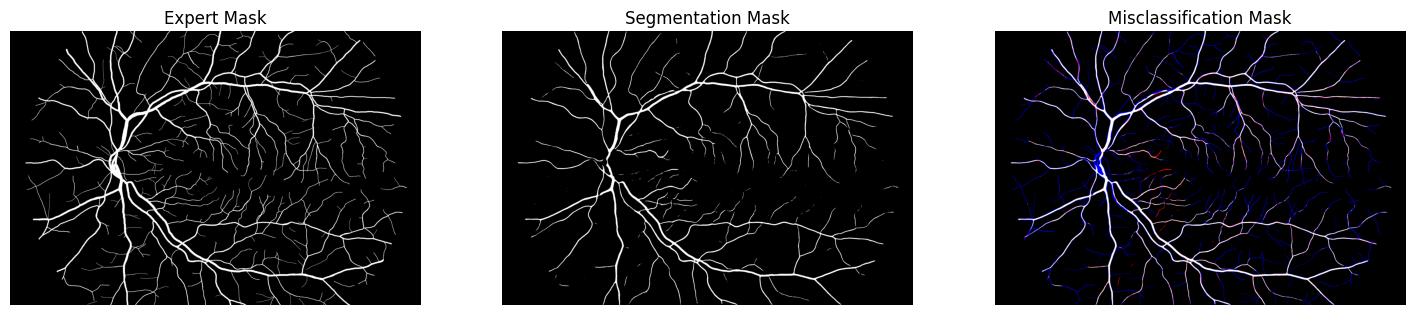

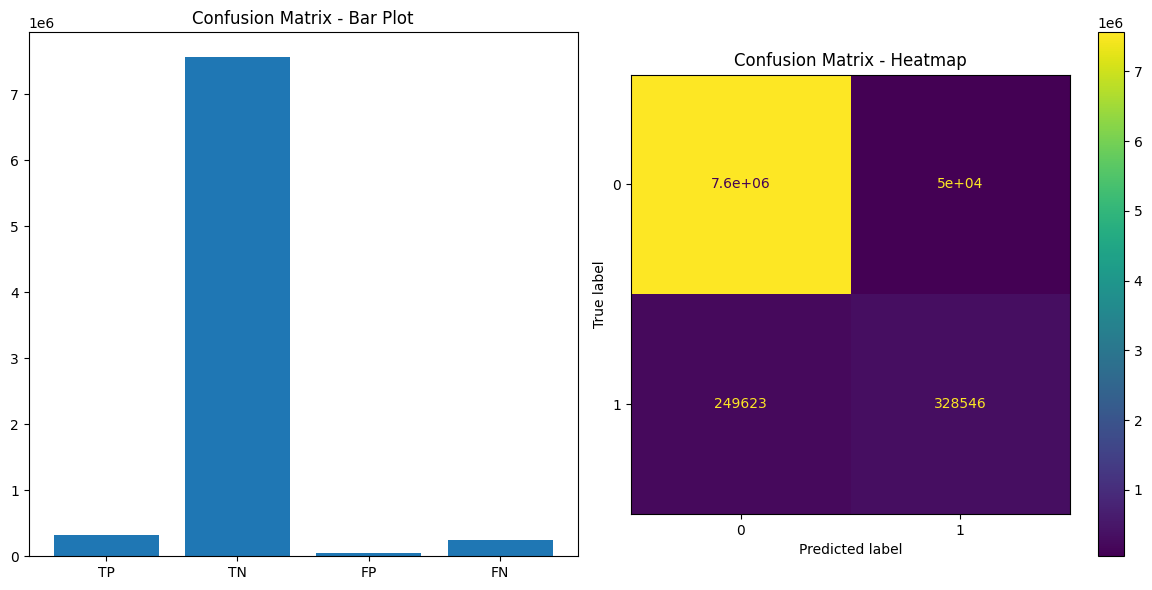

In [163]:
mv = MetricsVisualizer(y, predictions_pixels)
mv.calculate_metrics()
mv.visualize_metrics()